In [1]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for tile_atl08.py

In [2]:
import os
import geopandas
import pandas as pd
import glob
import datetime
!pip install xmltodict
import xmltodict
import sys
sys.path.append('/projects/Developer/icesat2_boreal/lib')
import ExtractUtils

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


  Using cached xmltodict-0.12.0-py2.py3-none-any.whl (9.2 kB)
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [141]:
%%time
!time python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 --dps_month_list 04 --maap_version tile_atl08

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		tile_atl08
Type:		ATL08_filt
Year:		2022
Month:		['04']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
                                             s3_path  ...                                               file
0  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220418_4483.csv
2  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220418_4476.csv
4  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220418_45970...
6  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220418_4

#### Set the names of the data frames to create

In [123]:
# Topo and Landsat tindex_master csvs from build_tindex_master.py
topo_tindex_fn    = "/projects/my-public-bucket/DPS_tile_lists/Topo_tindex_master.csv"
#landsat_tindex_fn = "/projects/my-public-bucket/DPS_tile_lists/Landsat_tindex_master.csv"
HLS_tindex_fn     = "/projects/my-public-bucket/DPS_tile_lists/HLS_tindex_master.csv"

topo_df = pd.read_csv(topo_tindex_fn)
hls_df = pd.read_csv(HLS_tindex_fn)

In [124]:

topo_df = pd.read_csv(topo_tindex_fn)
topo_df[topo_df.tile_num == 3457].local_path.tolist()[0].replace('/projects/my-private-bucket', 'https://s3.console.aws.amazon.com/s3/buckets/maap-ops-workspace/nathanmthomas')


'https://s3.console.aws.amazon.com/s3/buckets/maap-ops-workspace/nathanmthomas/dps_output/do_topo_stack_3-1-5_ubuntu/ops/2021/07/23/23/32/27/934649/Copernicus_3457_covars_cog_topo_stack.tif'

## Get tile ids for which both Topo and HLS stacks exist
* join on tile_num

In [125]:
model_ready_tiles_fn = "s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/model_ready_tiles.csv"
model_ready_tiles = hls_df[['tile_num','local_path']].join(topo_df[['tile_num','local_path']].set_index('tile_num'), how='inner', on='tile_num',lsuffix='_hls',rsuffix='_topo')
model_ready_tiles.to_csv(model_ready_tiles_fn)
if False:
    # Check some
    IDX = 4000
    print( model_ready_tiles.local_path_hls.to_list()[IDX])
    print( model_ready_tiles.local_path_topo.to_list()[IDX])

INPUT_TILE_NUM_LIST = model_ready_tiles.tile_num.to_list()
print(f'Total # tiles ready for tile_atl08.py :\t{len(INPUT_TILE_NUM_LIST)}')
model_ready_tiles.head()

Total # tiles ready for tile_atl08.py :	5178


,tile_num,local_path_hls,local_path_topo
0,4441,/projects/my-private-bucket/dps_output/do_HLS_...,/projects/my-private-bucket/dps_output/do_topo...
1,4476,/projects/my-private-bucket/dps_output/do_HLS_...,/projects/my-private-bucket/dps_output/do_topo...
2,38433,/projects/my-private-bucket/dps_output/do_HLS_...,/projects/my-private-bucket/dps_output/do_topo...
3,3189,/projects/my-private-bucket/dps_output/do_HLS_...,/projects/my-private-bucket/dps_output/do_topo...
4,4536,/projects/my-private-bucket/dps_output/do_HLS_...,/projects/my-private-bucket/dps_output/do_topo...


                      count
tile_group                 
alaska extra             20
canada extra             49
conus extra              98
eurasia central        1169
eurasia east           1098
eurasia north           159
eurasia west            612
europe north            358
fennoscand south         26
north america centra    714
north america east      494
north america west      470
uk                       70
Tile status report for ATL08_filt from s3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv:
	# of boreal tiles in boreal v003:			5337
	# of boreal tiles in water:				0
	# of boreal tiles used study (from Topo coverage):	5337
	# of boreal tiles with ATL08_filt:				4580
	# of boreal tiles still needing ATL08_filt from all:	757


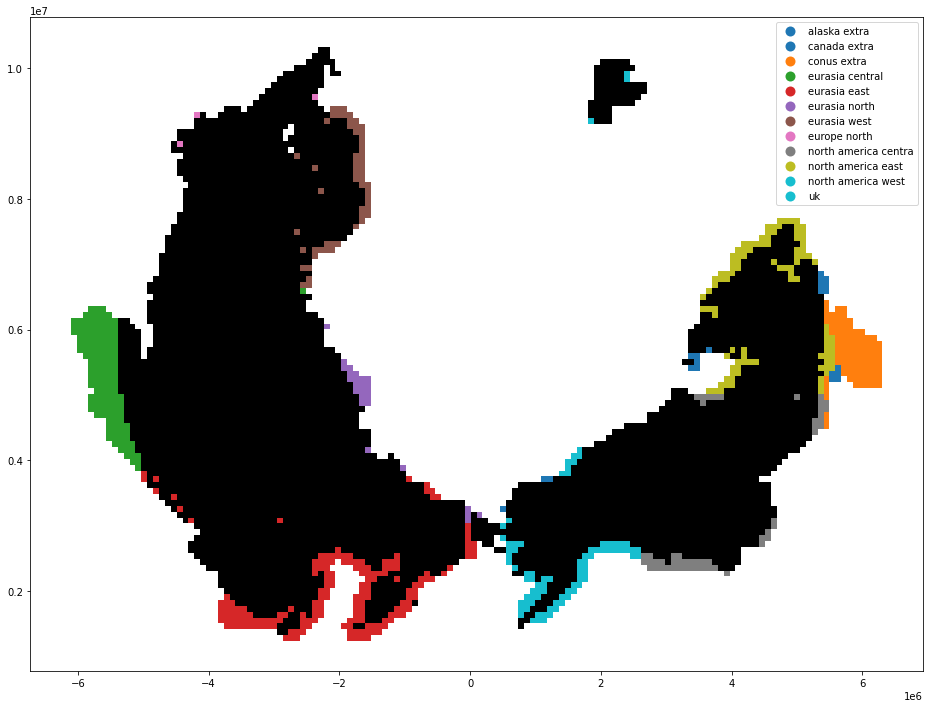

In [126]:
TILE_ATL08_TILES_NEEDED = ExtractUtils.GET_TILES_NEEDED(DPS_DATA_TYPE = 'ATL08_filt',  tindex_master_fn = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/ATL08_filt_tindex_master.csv', boreal_tile_index_path = '/projects/my-public-bucket/boreal_tiles_v003.gpkg')

#### Tiles needed (red)
* tiles below 45N wont process b/c extraction of ATL08 was done with min lat = 45N

757


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  """


289


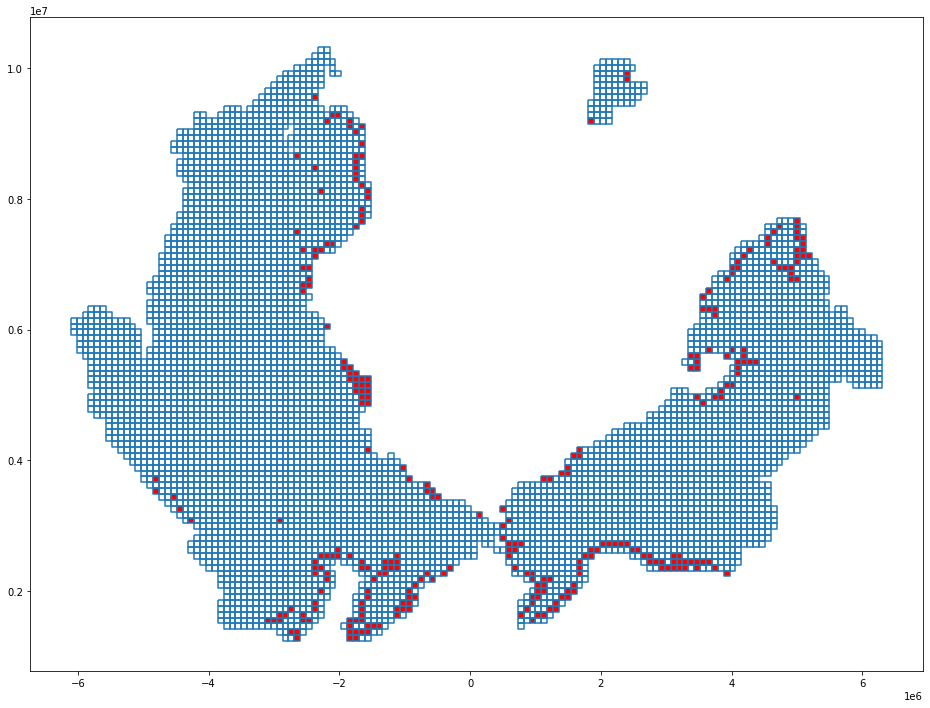

In [127]:
print(len(TILE_ATL08_TILES_NEEDED))
boreal_tile_index_path = '/projects/my-public-bucket/old_boreal_tiles/boreal_tiles_v003_old.gpkg'
boreal_tile_index = geopandas.read_file(boreal_tile_index_path)
ax=boreal_tile_index.boundary.plot()
boreal_tile_index_above45_model_ready = boreal_tile_index[(boreal_tile_index.tile_num.isin(model_ready_tiles.tile_num.to_list())) & (boreal_tile_index.tile_num.isin(TILE_ATL08_TILES_NEEDED)) & (boreal_tile_index.to_crs(4326).geometry.centroid.y > 45)]
boreal_tile_index_above45_model_ready.plot(color='red', ax=ax)
print(len(boreal_tile_index_above45_model_ready))

In [129]:
TILE_ATL08_TILES_NEEDED_above45 = boreal_tile_index_above45_model_ready.tile_num.to_list()

INPUT_TILE_NUM_LIST = TILE_ATL08_TILES_NEEDED_above45

# based on manual inspection in DPS review map
INPUT_TILE_NUM_LIST = [4253,3417]

len(INPUT_TILE_NUM_LIST)

2

##### Test: get a subset of tile ids for test tiles (Norway and others in NA)

In [130]:
DO_EXPERIMENT = False

if DO_EXPERIMENT:
    NORWAY_TILE_LIST = pd.read_csv('/projects/shared-buckets/lduncanson/misc_files/norway_tiles.csv').layer.tolist()

    DELTA_TILE_LIST = [3365,3366,3367,3458,3459,3460,3353,3354,3355] + [3361, 3362]
    BONA_TILE_LIST  = [3270,3271,3272, 3456,3457,  3363,3364,3365] + [3268, 3269]
    HEALY_TILE_LIST = [ 3551,3552,3553,3645,3646,3647] + [3648, 3649, 3555, 3554]

    #DELTA_TILE_LIST = [3365,3366,3367,3458,3460,3353,3354,3355,3549]
    #BONA_TILE_LIST  = [3270,3271,3272,3364,3456,3457,3458,3364,3365]
    #HEALY_TILE_LIST = [3456,3457,3458,3551,3552, 3553,3645,3646,3647]
    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + DELTA_TILE_LIST + BONA_TILE_LIST + HEALY_TILE_LIST
    ALASKA_TILE_LIST =  list(range(3268,3272+1))+\
                        list(range(3361,3366+1))+\
                        list(range(3454,3459+1))+\
                        list(range(3549,3555+1))+\
                        list(range(3643,3648+1))

    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + ALASKA_TILE_LIST
    len(INPUT_EXPERIMENT_TILE_NUM_LIST)

#### Read in the latest tindex and compare with a previous set of completed tiles to see which ones still need to be run

In [131]:
if DO_EXPERIMENT:
    import numpy as np
    #tindex_master_fn = '/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022/run_no_LC_height_thresholds/ATL08_filt_tindex_master.csv'
    NAME_TEST_SUBDIR = 'run_LC_height_thresholds_v2'
    tindex_master_DIR = f'/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022/{NAME_TEST_SUBDIR}'
    !python /projects/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m $NAME_TEST_SUBDIR -o $tindex_master_DIR

    tindex_master_fn = os.path.join(tindex_master_DIR, 'ATL08_filt_tindex_master.csv')
    tiles_completed = pd.read_csv(tindex_master_fn)

    print(f'Tiles completed: {len(tiles_completed)}')
    tile_nums_missing = np.setdiff1d(DPS_INPUT_TILE_NUM_LIST, tiles_completed.tile_num)
    print(f'Tiles missing: {len(tile_nums_missing)}')
    INPUT_EXPERIMENT_TILE_NUM_LIST = tile_nums_missing.tolist()
    print(len(INPUT_EXPERIMENT_TILE_NUM_LIST))

In [22]:
tindex_master_fn = f'/projects/shared-buckets/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv'
tiles = pd.read_csv(tindex_master_fn)
len(tiles)

46166

In [132]:
if DO_EXPERIMENT:
    tiles_completed_no_LC = pd.read_csv('/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022/run_no_LC_height_thresholds/ATL08_filt_tindex_master.csv')
    tiles_completed_LC = pd.read_csv('/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022/run_LC_height_thresholds/ATL08_filt_tindex_master.csv')
    print(f"# tiles for no LC:\t{len(tiles_completed_no_LC)}")
    print(f"# tiles for LC:\t\t{len(tiles_completed_LC)}")
    tile_nums_missing_no_LC = np.setdiff1d(INPUT_TEST_TILE_NUM_LIST, tiles_completed_no_LC.tile_num)
    tile_nums_missing_LC = np.setdiff1d(INPUT_TEST_TILE_NUM_LIST, tiles_completed_LC.tile_num)
    tile_nums_missing_no_LC = set(INPUT_TEST_TILE_NUM_LIST) - set(tiles_completed_no_LC.tile_num)
    tile_nums_missing_LC = set(INPUT_TEST_TILE_NUM_LIST) - set(tiles_completed_LC.tile_num)
    print(f"tiles missing for no LC:\t{tile_nums_missing_no_LC}")
    print(f"tiles missing for LC:\t\t{tile_nums_missing_LC}")

    #print(f"tiles for no LC:\t{tiles_completed_no_LC.tile_num}")
    #print(f"tiles for LC:\t\t{tiles_completed_LC.tile_num}")

    # The missing tiles common to both runs probably wont process b/c they have no ATL08 over land, or no corresponding Landsat or Topo tiles.
    # Those missing that are different in each set need to be run
    DPS_INPUT_TILE_NUM_LIST_no_LC = list(set(tiles_completed_LC.tile_num) - set(tiles_completed_no_LC.tile_num))
    DPS_INPUT_TILE_NUM_LIST_LC = list(set(tiles_completed_no_LC.tile_num) - set(tiles_completed_LC.tile_num))
    print(f"Tiles still needed for no LC run: {DPS_INPUT_TILE_NUM_LIST_no_LC}")
    print(f"Tiles still needed for LC run: {DPS_INPUT_TILE_NUM_LIST_LC}")

In [24]:
if DO_EXPERIMENT:
    month_dir_str = 'run_LC_height_thresholds'
    index_out_dir = os.path.join('/projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022', month_dir_str)
    !python /projects/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m $month_dir_str -o $index_out_dir

In [133]:
TEST_DPS  = False

if TEST_DPS:
    DPS_INPUT_TILE_NUM_LIST = INPUT_TEST_TILE_NUM_LIST
    
    if True:
        #!python /projects/icesat2_boreal/lib/build_tindex_master_v2.py -t ATL08_filt -y 2022 -m $month_dir_str -o $index_out_dir
        t = pd.read_csv(os.path.join(index_out_dir,'ATL08_filt_tindex_master.csv'))
        COMPLETED_TILES = t.tile_num.to_list()
        NEED_TILES = list(set(DPS_INPUT_TILE_NUM_LIST) - set(COMPLETED_TILES))

        print(NEED_TILES)
        DPS_INPUT_TILE_NUM_LIST = NEED_TILES
    
else:
    if DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        print('Running DPS on the FULL list of input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the FULL list of input
List length: 2


## Customize the DPS run (choose params, set up the params dictionary)

In [134]:
# Set a default params dict
in_param_dict = {
                        'in_tile_num': '',
                        'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                        'in_tile_layer': 'boreal_tiles_v003',
                        'csv_list_fn': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv',
                        'topo_stack_list_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv',
                        'landsat_stack_list_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Landsat_tindex_master.csv',
                        'landsat_cols_list': 'Blue Green Red NIR SWIR NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo', 
                        'years_list': '2020',
                        'user_stacks': 'nathanmthomas',
                        'user_atl08': 'lduncanson',
                        'thresh_sol_el': 0,
                        'v_ATL08': 5,
                        'minmonth': 6,
                        'maxmonth': 9,
                        'LC_filter': False
    }

# Norway test 01 --> run_no_LC_height_thresholds_v2
# Just include sol_el so we can use sol_el < 5
in_param_dict_norway01 = in_param_dict
in_param_dict_norway01['years_list']    = '2019 2020 2021'
in_param_dict_norway01['thresh_sol_el'] = 5
in_param_dict_norway01['minmonth']      = 4
in_param_dict_norway01['maxmonth']      = 10
in_param_dict_norway01['LC_filter']     = False

# Norway test 02 --> run_LC_height_thresholds_v2
# Use v005 ATL08, which will apply lc-based thresholds, extend to all months
# NOTE!! make sure you manually update to use the correct filter in tile_atl08.py
in_param_dict_norway02 = in_param_dict
in_param_dict_norway02['years_list']    = '2019 2020 2021'
in_param_dict_norway02['thresh_sol_el'] = 5
in_param_dict_norway02['minmonth']      = 4
in_param_dict_norway02['maxmonth']      = 10
in_param_dict_norway02['LC_filter']     = True

# Norway test 03 --> run_LC_height_thresholds_HLS
# same as test 02, but with HLS composites from 2019 - 2021
# NOTE: HLS composites have SWIR2 JulianDate yearDate
in_param_dict_norway03 = in_param_dict
in_param_dict_norway03['landsat_stack_list_fn'] = 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv'
in_param_dict_norway03['landsat_cols_list']     = 'Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate'
in_param_dict_norway03['years_list']            = '2019 2020 2021'
in_param_dict_norway03['thresh_sol_el']         = 5
in_param_dict_norway03['minmonth']              = 4
in_param_dict_norway03['maxmonth']              = 10
in_param_dict_norway03['LC_filter']             = True

In [135]:
in_param_dict = in_param_dict_norway03
in_param_dict

{'in_tile_num': '',
 'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
 'in_tile_layer': 'boreal_tiles_v003',
 'csv_list_fn': 's3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv',
 'topo_stack_list_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv',
 'landsat_stack_list_fn': 's3://maap-ops-workspace/shared/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv',
 'landsat_cols_list': 'Blue Green Red NIR SWIR SWIR2 NDVI SAVI MSAVI NDMI EVI NBR NBR2 TCB TCG TCW ValidMask Xgeo Ygeo JulianDate yearDate',
 'years_list': '2019 2020 2021',
 'user_stacks': 'nathanmthomas',
 'user_atl08': 'lduncanson',
 'thresh_sol_el': 5,
 'v_ATL08': 5,
 'minmonth': 4,
 'maxmonth': 10,
 'LC_filter': True}

In [65]:
#DPS_INPUT_TILE_NUM_LIST = DPS_INPUT_TILE_NUM_LIST[0:1]
DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[10:] #INPUT_TILE_NUM_LIST[0:10] #INPUT_TILE_NUM_LIST[10:]


## Run a DPS job across the list

In [136]:
RUN_NAME = 'atl08_with_hls'

In [137]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = 'run_tile_atl08'
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'lduncanson'
    WORKER_TYPE = 'maap-dps-worker-16gb'
    
    in_param_dict['in_tile_num'] = INPUT_TILE_NUM
    
    submit_result = maap.submitJob(
            identifier=IDENTIFIER,
            algo_id=ALGO_ID,
            version='tile_atl08',
            username=USER, # username needs to be the same as whoever created the workspace
            queue=WORKER_TYPE,
            **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE

    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 25,50, 100,200,300,400,500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 2
DPS run #: 1	| tile num: 4253	| submit status: success	| job id: 71768575-a404-427c-870a-da7966a80b1e
DPS run #: 2	| tile num: 3417	| submit status: success	| job id: 875d92ec-467f-4b38-8602-0239dd810c84
Current time:	202204211935
CPU times: user 26.1 ms, sys: 4.66 ms, total: 30.8 ms
Wall time: 433 ms


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name
0,success,200,71768575-a404-427c-870a-da7966a80b1e,1,4253,2022-04-21 19:35:28.277931,19,run_tile_atl08_ubuntu,lduncanson,maap-dps-worker-16gb,atl08_with_hls
0,success,200,875d92ec-467f-4b38-8602-0239dd810c84,2,3417,2022-04-21 19:35:28.356693,19,run_tile_atl08_ubuntu,lduncanson,maap-dps-worker-16gb,atl08_with_hls


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [140]:
%%time
LIST_SUBMISSIONS = sorted(glob.glob(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_*.csv'),key=ExtractUtils.func, reverse=True)
for DPS_DATETIME in ['202204211935']:
    for fn in LIST_SUBMISSIONS:
        if DPS_DATETIME in fn and not 'job_status' in fn:
            DPS_alg_id = os.path.basename(fn.split('_submission_results_')[0].replace('DPS_',''))
            thentime = fn.split('_')[-1].replace('.csv','')
            print(f'DPS alg:\t\t{DPS_alg_id}')
            print(f'DPS launch time:\t{thentime}')
            z = ExtractUtils.BUILD_TABLE_JOBSTATUS(pd.read_csv(fn))
            # Save job status table
            z.to_csv(f'/projects/my-public-bucket/dps_submission_results/DPS_{IDENTIFIER}_submission_results_job_status_{len(z)}_{thentime}.csv')

DPS alg:		run_tile_atl08
DPS launch time:	202204211935
Count total jobs:	2
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	2
Count failed jobs:	0
% of failed jobs:	Nothing has failed...yet

CPU times: user 35.1 ms, sys: 3.29 ms, total: 38.4 ms
Wall time: 1.31 s


In [112]:
DPS_INPUT_TILE_NUM_LIST = z[z['wps:Status'] =='Failed'].tile_num.to_list()

In [99]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Succeeded'].iloc[0].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            'b5524f4d-d4b6-4472-93b3-d3496cd30147'),
                           ('wps:Output',
                            OrderedDict([('@id',
                                          'output-2022-04-21T04:15:06.212846'),
                                         ('wps:Data',
                                          ['http://maap-ops-workspace.s3-website-us-west-2.amazonaws.com/lduncanson/dps_output/run_tile_atl08_ubuntu/tile_atl08/2022/04/21/04/15/06/212846',
                                           's3://s

In [110]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[20].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            '4daa6c40-429c-4458-a1af-655cc2eebdd4'),
                           ('wps:Output',
                            OrderedDict([('@id', 'traceback'),
                                         ('wps:Data',
                                          'activate does not accept more than one argument:\n[\'/app/icesat2_boreal/dps/alg_2-4/run_tile_atl08.sh\', \'4543\', \'boreal_tiles_v003\', \'s3://maap-ops-workspace/shared/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv\', \'s3://maap-ops-workspace/shared/nath

In [25]:
!python /projects/icesat2_boreal/lib/build_tindex_master.py -t ATL08_filt -y 2022 -m 03 -o /projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022/03

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		ATL08_filt
Year:		2022
Month:		03
Days:		1-31

Output dir:  /projects/my-private-bucket/dps_output/run_tile_atl08_ubuntu/master/2022/03
                                             s3_path  ...                                               file
0  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220329_0004.csv
2  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220329_0133.csv
4  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_30m_filt_topo_landsat_20220329_0131.csv
6  s3://maap-ops-workspace/lduncanson/dps_output/...  ...  atl08_005_3

[387, 388, 5, 6, 7, 10, 14, 16, 275, 21, 25, 27, 28, 29, 416, 37, 38, 296, 26025, 299, 300, 301, 48, 177, 50, 178, 60, 198, 3270, 72, 326, 327, 328, 26574, 354, 355, 356, 357, 247]


In [153]:
%%time
TILE_NUM = 131 #NEED_TILES[6]
args = f"\
-LC_filter True \
--extract_covars \
--do_30m \
--do_dps \
-years_list 2019 2020 2021 \
-o /projects/my-public-bucket/atl08_filt_covar_tiles \
-in_tile_num {TILE_NUM} \
-in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg \
-in_tile_layer boreal_tiles_v003 \
-in_tile_id_col tile_num \
-csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv \
-topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv \
-landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Landsat_tindex_master.csv \
-user_stacks nathanmthomas \
-user_atl08 lduncanson \
-thresh_sol_el 5 \
-v_ATL08 5 -minmonth 4 -maxmonth 10"
print(args)
!python /projects/icesat2_boreal/lib/tile_atl08.py $args

-LC_filter True --extract_covars --do_30m --do_dps -years_list 2019 2020 2021 -o /projects/my-public-bucket/atl08_filt_covar_tiles -in_tile_num 131 -in_tile_fn /projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg -in_tile_layer boreal_tiles_v003 -in_tile_id_col tile_num -csv_list_fn /projects/shared-buckets/lduncanson/DPS_tile_lists/ATL08_tindex_master.csv -topo_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv -landsat_stack_list_fn /projects/shared-buckets/nathanmthomas/DPS_tile_lists/Landsat_tindex_master.csv -user_stacks nathanmthomas -user_atl08 lduncanson -thresh_sol_el 5 -v_ATL08 5 -minmonth 4 -maxmonth 10
/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Land cover filtering set t